<a href="https://colab.research.google.com/github/panahiparham/NurIPS-Co-Author-Associations/blob/main/Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NurIPS Co-Author Associations

## Abstract
With the rapid advancement of science, the volume of published research papers is growing exponentially making the task of searching and finding relevant articles especially difficult for students and researchers. Another issue is the increased complexity in the relationships between papers, their references, and their authors. This study focuses on using the A-priori algorithm to find frequent co-authors of papers and then extract pair-wise association rules between them. These tasks are performed on the NurIPS papers database. 

## Purpose 
This project aims to find interesting relationships between Researchers publishing papers in the Neural Information Processing Systems Journal.In particular we are interested in three questions:
  1. Who are the most published NIPS authors and their publications?
  2. Which groups of researchers have published several papers together?
  3. Which frequent authors, have always colaborated with a specific co-author?

The purpose of this work is to better understand the research landscape of Deep Learning and ease the process of finding interesting researchers and papers.


## Overview of Project
 * Extracting data
  - Web scraping with beautifulSoup
  - Hashing and storing paper and author names to disk
 * A-priori Algorithm for frequent pair mining
  - Implementing 2 pass A-priori
  - Implementing general multi-pass A-priori
 * Association Mining
  - Generating association rules
  - Gerfect implications
 * Discussion
  - Confidence vs. Interestingness
  - Future work
  - Final note


 <em>
 </br>
This work is designed as the final project for "Algorithms for Datascience" class offered at Shahid Beheshti University in Fall 2021.</br>
<b>Instructor</b>: Dr. Ali Katanforoush</br>
<b>Student</b>: Parham Mohammad Panahi (student id: 400422166)
 </em>

# Extracting data

## Web scraping with beautifulSoup
NIPS posts lists of accepted papers on their website. In order to have access to papers and their authors we need to gather this data from NIPS website, [NeurIPS Proceedings](https://papers.nips.cc/).

This page links to lists of papers for different years, we can scape these pages with [BeautifulSoup](https://beautiful-soup-4.readthedocs.io/).

In [ ]:
from bs4 import BeautifulSoup
import requests
import time
import csv

import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, product

In [ ]:
# path to site
root_path = 'https://papers.nips.cc/paper/'

In [ ]:
# extract paper title, year of publishing, and author names for NIPS papers in a given year.
def extract_paper_info(year = 2020):
  r = requests.get(root_path + '/' + str(year))
  soup = BeautifulSoup(r.text, 'html.parser')
  papers_list = soup.find(class_='col').find_all('li')
  return map(lambda x: {'title':x.a.text, 'authors':x.i.text.split(', '), 'year':year}, papers_list)

In [ ]:
# Extract all paper data from 1998 to 2021
counter = 0

with open('nips_authors.csv', 'w') as csvfile:
  writer = csv.writer(csvfile, delimiter=',')

  for year in range(1998, 2022, 1):
    # sleep the program between calls to server not to overload servers with requests
    time.sleep(1)
    for paper in extract_paper_info(year=year):  
      title = paper['title']
      year = paper['year']
      authors = paper['authors']
      row = [title] + [year] + authors

      # write (title, year, author_1, author_2, ...) to disk
      writer.writerow(row)
      counter += 1

print(f'found {counter} papers!')

found 12461 papers!


## Hashing and storing paper and author names to disk

We found over 10 thousand papers! To easily store and work with our data, we can hash each paper title and author names to a 32 bit integer and store these hash values to a csv of the form

```
paper_id, author_id, author_id, ...
paper_id, author_id, author_id, ...
paper_id, author_id, author_id, ...
...
```
 
 We also save a key value pair of id_2_author and id_2_paper to be able to easily convert hash values back to string representation later on.

In [ ]:
# two dictionaries to perform inverse hashing on ids
id_2_paper = {}
id_2_author = {}

with open('nips_authors_id.csv', 'w') as writing_to:
  writer = csv.writer(writing_to, delimiter=',')
  with open('nips_authors.csv', 'r') as reading_from:
    reader = csv.reader(reading_from, delimiter=',')
    for row in reader:
      title = row[0]
      year = row[1]
      authors = row[2:]
      row = []

      # keeping only the first 32 bits of the hash value
      paper_id = hash(title) & ((1<<32)-1)
      id_2_paper[paper_id] = (title, year)
      row.append(paper_id)

      for author in authors:
        author_id = hash(author) & ((1<<32)-1)
        id_2_author[author_id] = author
        row.append(author_id)

      # write (paper_id, author_id, author_id, ...) to disk
      writer.writerow(row)

In [ ]:
print(f'Found {len(id_2_paper)} papers in total!')
print(f'Written by {len(id_2_author)} distinct authors')

Found 12461 papers in total!
Written by 20263 distinct authors


It looks like there are over $12000$ papers published in NIPS since its inception, with over $20000$ distinct researchers contributing to this figure.

In order to count the number of papers on which any two authors worked together, we need $ 20263 \times 20262 \times 0.5 * 4 = 821137812$ bytes of memory which translates to about $820$ megabytes of ram. This is no issue as any modern computer holds more than $10$ times that amount of memory, therefore we can keep the counts in RAM.

But of course this method is not scalable. Imagine we were faced with twice the number of authors(~40k), which is quite reasonable. In that situation we would have required, around $3.2$ Gigabytes of RAM. For 80k authors, we would need $12.8$GB. As you can see, the amount of required RAM quickly gets out of control, therefore, instead of counting pair counts in main memory, we perform more than one pass over the data, and make smarter use of our memory.

# A-priori Algorithm for frequent pair mining

## Implementing 2 pass A-priori

To find frequent co-authors we use the A-priori algorithm which consists of two passes over the entire dataset
 - pass 1: find frequent authors.
  - the idea is by finding authors who haven't written a lot of papers, we can cross them out as candidates of being in a pair of frequent authors.
 -pass 2: count occurances of pairs of authors, only when each party is frequent by themselves.


with this method we can find frequent pairs of authors, a generalisation of this approach is used to find larger frequent itemsets. But for now let us implement the simple variation of A-priori.

In [ ]:
# Pass 1: count frequent authors

# we use a dictionary to keep track of counts
author_counts = {}

with open('nips_authors_id.csv', 'r') as f:
  reader = csv.reader(f, delimiter=',')
  for row in reader:
    for author_id in row[1:]:
      # update counts dictionary
      if author_id in author_counts:
        author_counts[author_id] += 1
      else:
        author_counts[author_id] = 1

In [ ]:
print('number of unique authors: ',len(author_counts))
print('each author published between 1 and', max(list(author_counts.values())), 'papers')

number of unique authors:  20263
each author published between 1 and 79 papers


Note that no author has written more than 79 papers!

We will use this fact later on.

## Answering question 1

Who are the most published NIPS authors and their publications?


We will consider the the few authors with more than 50 published papers in NIPS,

In [ ]:
select_authors = []

# look for most frequent authors
for k in author_counts:
  if author_counts[k] > 50:
    print(id_2_author[int(k)], author_counts[k])
    select_authors.append(k)

Michael Jordan 69
Bernhard Schölkopf 79
Tong Zhang 53
Yoshua Bengio 71
Francis Bach 67
Russ R. Salakhutdinov 59
Lawrence Carin 57
Andreas Krause 55
Sergey Levine 56


In [ ]:
# search for publications of the most published authors
publications = {auth:[] for auth in select_authors}

with open('nips_authors_id.csv', 'r') as f:
  reader = csv.reader(f, delimiter=',')
  for row in reader:
    paper_id = row[0]
    for author_id in row[1:]:
      if author_id in publications:
        publications[author_id].append(paper_id)

In [ ]:
for auth in publications:
  print(id_2_author[int(auth)])
  for paper in publications[auth]:
    print(f'\t{id_2_paper[int(paper)]}')

Michael Jordan
	('Learning from Dyadic Data', '1998')
	('Approximate Inference A lgorithms for Two-Layer Bayesian Networks', '1999')
	('Latent Dirichlet Allocation', '2001')
	('Thin Junction Trees', '2001')
	('On Discriminative vs. Generative Classifiers: A comparison of logistic regression and naive Bayes', '2001')
	('On Spectral Clustering: Analysis and an algorithm', '2001')
	('Minimax Probability Machine', '2001')
	('Learning Graphical Models with Mercer Kernels', '2002')
	('A Minimal Intervention Principle for Coordinated Movement', '2002')
	('Distance Metric Learning with Application to Clustering with Side-Information', '2002')
	('A Hierarchical Bayesian Markovian Model for Motifs in Biopolymer Sequences', '2002')
	('Robust Novelty Detection with Single-Class MPM', '2002')
	('Statistical Debugging of Sampled Programs', '2003')
	('Semidefinite Relaxations for Approximate Inference on Graphs with Cycles', '2003')
	('Large Margin Classifiers: Convex Loss, Low Noise, and Convergence

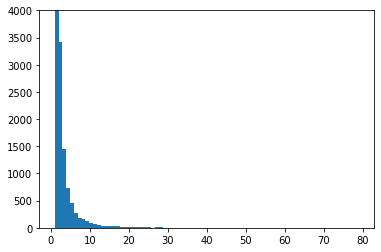

In [ ]:
fig = plt.hist(np.array(list(author_counts.values())), bins= 79)
_ = plt.ylim(0, 4000)

Most authors have published only one paper. therefore, we need to pick a small enough support threshold value (under 10)

In [ ]:
support_threshold = 10

In [ ]:
# between passes, find frequent authors
frequent_authors = []

for author in author_counts:
  if author_counts[author] >= support_threshold:
    frequent_authors.append(author)


print('number of frequent authors:', len(frequent_authors))

number of frequent authors: 570


In [ ]:
# pass 2: count only pairs when both authors are frequent
pair_counts = {}

with open('nips_authors_id.csv', 'r') as f:
  reader = csv.reader(f, delimiter=',')
  for row in reader:
    for author_x, author_y in combinations(row[1:], 2):
      if author_x in frequent_authors and author_y in frequent_authors:
        # update pair counts dictionary
        pair = frozenset({author_x, author_y})
        if pair in pair_counts:
          pair_counts[pair] += 1
        else:
          pair_counts[pair] = 1

In [ ]:
# filter out non-frequent pairs

frequent_pairs = []

# between passes, find frequent pairs
for pair in pair_counts:
  if pair_counts[pair] >= support_threshold:
    frequent_pairs.append(pair)


print('number of frequent author pairs:', len(frequent_pairs))

number of frequent author pairs: 30


List of pairs of authors who have published at least 10 NIPS papers together

In [ ]:
for pair in list(map(lambda x: set(x), frequent_pairs)):
  for auth in pair:
    print(id_2_author[int(auth)], end='\t')
  print()

Alex Smola	Bernhard Schölkopf	
Ralf Herbrich	Thore Graepel	
Mehryar Mohri	Corinna Cortes	
Alyson K. Fletcher	Sundeep Rangan	
Bo Zhang	Jun Zhu	
Masashi Sugiyama	Gang Niu	
Tianbao Yang	Rong Jin	
Pradeep K. Ravikumar	Inderjit S. Dhillon	
Praneeth Netrapalli	Prateek Jain	
Tie-Yan Liu	Tao Qin	
Jiashi Feng	Shuicheng Yan	
Lorenzo Rosasco	Alessandro Rudi	
Florent Krzakala	Lenka Zdeborová	
Remi Munos	Michal Valko	
Han Liu	Zhaoran Wang	
Ricardo Henao	Lawrence Carin	
Jiajun Wu	Bill Freeman	
Jiajun Wu	Josh Tenenbaum	
Josh Tenenbaum	Bill Freeman	
Chang Xu	Yunhe Wang	
David Silver	Hado P. van Hasselt	
Zhuoran Yang	Zhaoran Wang	
Mingsheng Long	Jianmin Wang	
Sergey Levine	Chelsea Finn	
Cho-Jui Hsieh	Huan Zhang	
Stefano Ermon	Jiaming Song	
Alessandro Lazaric	Matteo Pirotta	
Stefano Ermon	Yang Song	
Tamer Basar	Kaiqing Zhang	
Tianlong Chen	Zhangyang Wang	


## Implementing general multi-pass A-priori

We can find bigger frequent itemsets by abstracting A-priori into two parts and repeatedly running them sequentially:

```
genCandidates(size=1) -> filter_candidates -> genCandidates(size=2) -> filter_candidates -> genCandidates(size=3) -> filter_candidates -> ...

```
```
frequentSets(n-1), frequentSets(1) -> gencandidates -> CandidateSets(n)
CandidateSets(n) -> filter_candidates(n) -> frequentSets(n)
```

In [ ]:
def gen_candidates(frequent_sets, frequent_items):
  # frequent_sets -> list of frequent sets of size n-1
  # frequent_items -> list of frequent items(singletons)
  # candidates -> list of set of candidate items

  n = len(frequent_sets[0])

  # generate all possible sets by picking a frequent set (size: n-1) and a frequent item (size: 1)
  candidates = map(lambda x:x[0]|x[1], product(frequent_items, frequent_sets))

  # filter out all cases where we merge by an item already in the set (e.g. {x} | {x,y})
  candidates = filter(lambda x: len(x) == n + 1, candidates)

  return list(candidates)

In [ ]:
def filter_candidates(candidates):
  # candidates -> list of candidate sets of size n
  # frequent_sets -> list of verified frequent sets

  # what size itemset are we looking for
  n = len(candidates[0])

  candidateset = {frozenset(x) for x in candidates}

  counts = {}

  with open('nips_authors_id.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
      # for all possible combinations of n elements in each basket
      for items in combinations(row[1:], n):
        if set(items) in candidateset:
          # update counts dictionary
          frozen_items = frozenset(items)
          if frozen_items in counts:
            counts[frozen_items] += 1
          else:
            counts[frozen_items] = 1


  # filter out items below support threshold
  frequent_sets = filter(lambda x: counts[x] >= support_threshold, counts)
  frequent_sets = list(map(lambda x: set(x), frequent_sets))



  return frequent_sets, counts

In [ ]:
# lowering the threshold to find more frequent co-authors
support_threshold = 5

frequent_authors = []

# find frequent authors
for author in author_counts:
  if author_counts[author] >= support_threshold:
    frequent_authors.append(author)


print('number of frequent authors:', len(frequent_authors))

number of frequent authors: 1786


In [ ]:
# repeatedly run A-priori to capture all frequent itemsets

frequent_items = list(map(lambda x: {x}, frequent_authors))

# keep a list of all frequent itemsets
frequent_sets = []
# keep count of all candidate itemset counts (including the frequent ones)
counts_dict = {}

# update aggregates with size 1 itemsets
frequent_sets.append(frequent_items)
counts_dict.update({frozenset({x}):author_counts[x] for x in author_counts})


k = 0
# repeat until there exists a larger candidate
while len(frequent_sets[k]) != 0:
  # run both A-priori passes
  candidates = gen_candidates(frequent_sets[k],frequent_items)
  freq_sets, counts = filter_candidates(candidates)
  
  # update aggregates with size n itemsets
  frequent_sets.append(freq_sets)
  counts_dict.update(counts)
  k += 1

## Answering question 2

Which groups of researchers have published several papers together?

We will consider a support threshold of 5 papers (groups must have at least 5 papers together to be considered frequent)

In [ ]:
print('number of frequent pairs:', len(frequent_sets[1]))
print('number of frequent triples:', len(frequent_sets[2]))
print('number of frequent quadruples:', len(frequent_sets[3]))
print('number of frequent quintuples:', len(frequent_sets[4]))
print('number of frequent sextuples:', len(frequent_sets[5]))

number of frequent pairs: 407
number of frequent triples: 68
number of frequent quadruples: 30
number of frequent quintuples: 12
number of frequent sextuples: 2


In [ ]:
# Groups of 3 authors who have at least 5 NIPS papers together
for team in frequent_sets[3]:
  for auth in map(lambda x:id_2_author[int(x)], team):
    print(auth, end='  ')
  print()

Shinji Ito  Takuro Fukunaga  Daisuke Hatano  Hanna Sumita  
Shinji Ito  Naonori Kakimura  Daisuke Hatano  Hanna Sumita  
Shinji Ito  Daisuke Hatano  Ken-Ichi Kawarabayashi  Hanna Sumita  
Shinji Ito  Takuro Fukunaga  Daisuke Hatano  Naonori Kakimura  
Shinji Ito  Takuro Fukunaga  Daisuke Hatano  Ken-Ichi Kawarabayashi  
Shinji Ito  Naonori Kakimura  Daisuke Hatano  Ken-Ichi Kawarabayashi  
Shinji Ito  Takuro Fukunaga  Naonori Kakimura  Hanna Sumita  
Shinji Ito  Takuro Fukunaga  Ken-Ichi Kawarabayashi  Hanna Sumita  
Shinji Ito  Naonori Kakimura  Ken-Ichi Kawarabayashi  Hanna Sumita  
Shinji Ito  Takuro Fukunaga  Naonori Kakimura  Ken-Ichi Kawarabayashi  
Takuro Fukunaga  Naonori Kakimura  Daisuke Hatano  Hanna Sumita  
Takuro Fukunaga  Daisuke Hatano  Ken-Ichi Kawarabayashi  Hanna Sumita  
Naonori Kakimura  Daisuke Hatano  Ken-Ichi Kawarabayashi  Hanna Sumita  
Takuro Fukunaga  Naonori Kakimura  Daisuke Hatano  Ken-Ichi Kawarabayashi  
Takuro Fukunaga  Naonori Kakimura  Ken-Ichi Kawar

In [ ]:
# Groups of 5 authors who have at least 5 NIPS papers together
for team in frequent_sets[4]:
  for auth in map(lambda x:id_2_author[int(x)], team):
    print(auth, end='  ')
  print()

Shinji Ito  Takuro Fukunaga  Hanna Sumita  Naonori Kakimura  Daisuke Hatano  
Shinji Ito  Takuro Fukunaga  Ken-Ichi Kawarabayashi  Hanna Sumita  Daisuke Hatano  
Shinji Ito  Ken-Ichi Kawarabayashi  Hanna Sumita  Naonori Kakimura  Daisuke Hatano  
Shinji Ito  Takuro Fukunaga  Ken-Ichi Kawarabayashi  Naonori Kakimura  Daisuke Hatano  
Shinji Ito  Takuro Fukunaga  Hanna Sumita  Naonori Kakimura  Ken-Ichi Kawarabayashi  
Takuro Fukunaga  Ken-Ichi Kawarabayashi  Hanna Sumita  Naonori Kakimura  Daisuke Hatano  
Zhongwen Xu  Hado P. van Hasselt  Junhyuk Oh  David Silver  Matteo Hessel  
Zhongwen Xu  Hado P. van Hasselt  Satinder Singh  Junhyuk Oh  Matteo Hessel  
Zhongwen Xu  Satinder Singh  Junhyuk Oh  David Silver  Matteo Hessel  
Zhongwen Xu  Hado P. van Hasselt  Satinder Singh  David Silver  Matteo Hessel  
Hado P. van Hasselt  Satinder Singh  Junhyuk Oh  David Silver  Matteo Hessel  
Zhongwen Xu  Satinder Singh  Junhyuk Oh  David Silver  Hado P. van Hasselt  


In [ ]:
# Groups of 6 authors who have at least 5 NIPS papers in common
for team in frequent_sets[5]:
  for auth in map(lambda x:id_2_author[int(x)], team):
    print(auth, end='  ')
  print()

Shinji Ito  Takuro Fukunaga  Ken-Ichi Kawarabayashi  Hanna Sumita  Naonori Kakimura  Daisuke Hatano  
Zhongwen Xu  Hado P. van Hasselt  Satinder Singh  Junhyuk Oh  David Silver  Matteo Hessel  


# Association Mining

## Generating association rules

Association rules are frequent IF-THEN occurances of events together. For example if $\{i_1,\dots,i_n\}$ is a frequent itemset, $\{i_2,\dots,i_n\} \to i_1$ is an association rule. But not all such rules are that interesting.

For example, If we have 100 frequent pairs of items then there are 200 association rules of the form $[x \to y]$. However, most of these rules don't give us actual information about relationships between items. Maybe the two items are independently frequent and therefore show up together many times or perhaps some items co-occur with many different items in different circumstances thus not giving us a useful IT-THEN relationship.

There are several measures of "goodness" for association rules. Let us introduce one such measure called "confidence".

### Confidence

Confidence measures what fraction of times $\{i_2,\dots,i_n\}$ co-occur with $\{i_1\}$. Namely, if $ I =\{ i_2, \dots, i_n \}$, then,
$$
\text{Confidence}(I \to i_1) = \frac{\text{Support}(I \cup \{i_1\})}{\text{Support}(I)}
$$

Let's find association rules of the form:
$$
X \to Y
$$
For frequent pairs (support threshold = 5)

In [ ]:
# find associations
# X -> Y   associations[(X,Y)] = conf(X->Y)
associations = {}


freq_pairs = frequent_sets[1]

for pair in freq_pairs:
  # {X,Y}
  pair = list(pair)

  # X -> Y
  X = pair[0]
  Y = pair[1]
  associations[X,Y] = None

  # Y -> X
  X = pair[1]
  Y = pair[0]
  associations[X,Y] = None

In [ ]:
# calculate confidence of associations
for association in associations:
  # I -> j
  I = {association[0]}
  j = {association[1]}
  
  associations[association] =  counts_dict[frozenset(I | j)] / counts_dict[frozenset(I)]

In [ ]:
# Association confidence of pairs for support thereshold 5
associations

{('1001356832', '1473784883'): 0.1935483870967742,
 ('1001356832', '3390784942'): 0.16129032258064516,
 ('1001356832', '4144433279'): 0.25806451612903225,
 ('1001356832', '748457644'): 0.22580645161290322,
 ('1001455660', '2355635187'): 0.8333333333333334,
 ('1004145066', '1271151121'): 0.8571428571428571,
 ('1007220190', '4097041451'): 0.25,
 ('1029041475', '1983995262'): 0.21428571428571427,
 ('1029041475', '212160062'): 0.5,
 ('1029041475', '2344999919'): 0.17857142857142858,
 ('1029041475', '2654352847'): 0.32142857142857145,
 ('1029041475', '428475226'): 0.21428571428571427,
 ('1029829025', '4017234740'): 0.25,
 ('1050619812', '406844425'): 0.4166666666666667,
 ('1054694307', '872811929'): 0.3888888888888889,
 ('1056844424', '1889764238'): 0.7142857142857143,
 ('1091790929', '2023891181'): 0.2777777777777778,
 ('1091790929', '2493318935'): 0.5,
 ('1111677806', '3253308491'): 0.4166666666666667,
 ('111482447', '584759982'): 0.7142857142857143,
 ('1118746000', '1514060377'): 0.45454

## Perfect implications

Some associations have a confidence of 1. which means occurance of $\{i_1\}$ is completely determined by occurance of $\{i_2,\dots,i_n\}$.

These associations rules can be thought of as implications. For example, if $X \to Y$ has a confidence of 1, then, if we see $X$ in an item basket, we will be sure that $Y$ also exists in that item basket (given our limited knowledge of the universe based on the dataset of course!).

## Answering question 3

which frequent authors, have always colaborated with a specific co-author.

We will consider a support threshold of 5 papers (pairs must have at least 5 papers together to be considered frequent) and require the confidence of association to be 1 (perfect implication).

In [ ]:
# perfect implications for support value 5
# having written at least 5 NIPS papers together
for k in associations:
  if associations[k] == 1.0:
    X = id_2_author[int(k[0])]
    Y = id_2_author[int(k[1])]
    print(f'{X} -> {Y}')

Sebastian Mika -> Gunnar Rätsch
Andreas Ziehe -> Klaus-Robert Müller
Benjamin Blankertz -> Klaus-Robert Müller
Bernd Porr -> Florentin Wörgötter
Corinna Cortes -> Mehryar Mohri
Hongjing Lu -> Alan L. Yuille
Dongryeol Lee -> Alexander Gray
Xuejun Liao -> Lawrence Carin
Phil Long -> Rocco Servedio
Michael Lyu -> Irwin King
Alyson K. Fletcher -> Sundeep Rangan
Sundeep Rangan -> Alyson K. Fletcher
Jun Liu -> Jieping Ye
Yao-liang Yu -> Dale Schuurmans
Arthur Choi -> Adnan Darwiche
Richard L. Lewis -> Satinder Singh
Arthur Guez -> David Silver
Fang Han -> Han Liu
Sanghack Lee -> Elias Bareinboim
Rishabh K. Iyer -> Jeff A. Bilmes
Itay Hubara -> Daniel Soudry
Greg Ver Steeg -> Aram Galstyan
Vitaly Kuznetsov -> Mehryar Mohri
Scott Yang -> Mehryar Mohri
Xiangru Lian -> Ji Liu
Jean-Bastien Grill -> Michal Valko
Kevin Ellis -> Josh Tenenbaum
Kiran K. Thekumparampil -> Sewoong Oh
Felix Xinnan X. Yu -> Sanjiv Kumar
Ashish Khetan -> Sewoong Oh
Hakan Bilen -> Andrea Vedaldi
Shengjia Zhao -> Stefano Er

# Discussion

## Confidence vs. Interestingness

One criticism of confidence measure is that it might not return truly interesting results. For example, consider a market basket example. Suppose the basket $\{milk, bread\}$ is frequent and $[milk \to bread]$ has high confidence. This means that many customers bought milk and bread together, and if a basket contains milk then with high probability it contains bread.

This seems an interesting association rule, but consider if bread is bought so commonly that most baskets contain bread irrespective of whether it also contained milk or not. In this situation $[milk \to bread]$ is not interesting because we can replace milk with any other frequent item and still get a high confidence association rule.

To remedy this issue, we can use "interestingness" which measures the gap between confidence of $[x\to y]$ and probability of $y$ being in a given basket,
$$
\text{interest}(x \to y) = |\text{conf}(x \to y) - P[y]|.
$$

In our specific work however we don't need to worry about this problem because (as mentioned before) the most published author has 79 NurIPS papers, in comparison to 12461 total papers. Therefore, no author has a high probability of working on a given paper ($P[y] \approx 0$) which implies that in our study,
$$
\text{interest}(x \to y) \approx \text{conf}(x \to y).
$$

## Future work

There are a lot of areas for investigation when it comes to analyzing publications and relationship between them. Here we mention two such avenues for future research.

### References association mining

We can perform a market basket analysis (similar to what we performed here) on references of each paper. This might reveal interesting co-citation relationships between papers and frequent co-citations can lead to recognition of bundles of few papers at the core of each research area. This can ease the process of reading and understanding the literature.

### Tracking impact of a paper with PageRank

Consider a graph where each node is a paper and edges are references between papers. In this model, a topic specific PageRank with a teleport set of $\{x\}$ can illuminate the reach of $x$ as it's effect flows through the network of papers.


## Final note

The final objective of the study at hand and these potential avenues for expansion is to better navigate the large volume of research articles being published every year. To help students and researchers by deligating the task of finding good papers and focusing on understanding relationships and connections.